<small><i>This notebook was put together by [Anderson Banihirwe](https://andersy005.github.io/) as part of [2017 CISL/SIParCS Research Project](https://ncar.github.io/PySpark4Climate/): **PySpark for Big Atmospheric & Oceanic Data Analysis**</i></small>

# Mean

- Defined as the arithmetic average of the set.
- Calculated by summing all values, then dividing by the number of values.
- One of the simplest measures of center to calculate.
- May provide an incomplete description of the central tendency if not accompanied by other measures.
- Greatly affected by extreme values.

# Example:

- Calculate the temporal, spatial, and zonal mean of temperature data over eastern North America for the period 2006-2010.
- The dataset can be found on [NCAR's Glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces): 

  - ```/glade/p/CMIP/CMIP5/output1/NOAA-GFDL/GFDL-ESM2M/rcp85/mon/atmos/Amon/r1i1p1/v20111228/ta/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc```

# Step 1: Load Dataset in a Spark dataframe

In [1]:
from pyspark4climate import read
from pyspark4climate.functions import shift_lon_udf
from pyspark.sql import SparkSession
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 15)
%matplotlib inline
import matplotlib.pyplot as plt
jet=plt.get_cmap('coolwarm')  # Used for multiple scatter plots

In [2]:
spark = SparkSession.builder.appName("mean").getOrCreate()
sc = spark.sparkContext

In [3]:
!ncdump -h ../data/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc

netcdf ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012 {
dimensions:
	plev = 17 ;
	time = UNLIMITED ; // (60 currently)
	lat = 90 ;
	lon = 144 ;
	bnds = 2 ;
variables:
	double plev(plev) ;
		plev:units = "Pa" ;
		plev:long_name = "pressure" ;
		plev:axis = "Z" ;
		plev:positive = "down" ;
		plev:standard_name = "air_pressure" ;
	double average_DT(time) ;
		average_DT:long_name = "Length of average period" ;
		average_DT:units = "days" ;
	double average_T1(time) ;
		average_T1:long_name = "Start time for average period" ;
		average_T1:units = "days since 2006-01-01 00:00:00" ;
	double average_T2(time) ;
		average_T2:long_name = "End time for average period" ;
		average_T2:units = "days since 2006-01-01 00:00:00" ;
	double lat(lat) ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:bounds = "lat_bnds" ;
	double lon(lon) ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:standard_name = "longitude"

In [4]:
filename='../data/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc'
var = 'ta'

In [5]:
data = read.DataFrame(sc, (filename, var), mode='single')

Pyspark4climate DataFrame class returns an object.
In order to access spark's dataframe we need to do the following:

In [6]:
type(data)

pyspark4climate.read.DataFrame

In [7]:
data_df = data.df
type(data_df)

pyspark.sql.dataframe.DataFrame

In [8]:
data_df.show()

+-------------------+--------+------------------+------------------+----+
|               time|    plev|               lat|               lon|  ta|
+-------------------+--------+------------------+------------------+----+
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            256.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            258.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            261.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            263.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            266.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            268.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            271.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|273.74999999999994|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            276.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            278.75|null|
|2006-01-16 12:00:00|100000.0|-71.7977

In [9]:
# Print the schema of data_df dataframe
data_df.printSchema()

root
 |-- time: string (nullable = true)
 |-- plev: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- ta: double (nullable = true)



# Step 2: Shift longitudes on grid so that they are in range [-180 -> 180]

To achieve this we will use ```pyspark4climate``` builtin function ```shift_grid_udf()```

In [10]:
# Shift grid and Drop the lon column
data_df = data_df.withColumn("shifted_lon", shift_lon_udf(data_df["lon"])).cache()
data_df = data_df.selectExpr("time", "plev", "lat", "shifted_lon as lon", "ta")

In [11]:
data_df.show()

+-------------------+--------+------------------+-------------------+----+
|               time|    plev|               lat|                lon|  ta|
+-------------------+--------+------------------+-------------------+----+
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            -103.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            -101.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -98.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -96.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -93.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -91.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -88.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527| -86.25000000000006|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -83.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -81.25|null|
|2006-01-16 12:00:00|1000

# Step 2: Select Temporal and Spatial Domains

Select North-America: Region with only values 60W to 130W, 20N to 70N

In [12]:
import pyspark.sql.functions as F

In [13]:
df = data_df.filter((data_df["lon"] <= -60) & (data_df["lon"] >=-130) &\
                 (data_df["lat"] >=20) & (data_df["lat"] <=70))\
                 .orderBy(F.col('time'), F.col('lat'), F.col('lon'))
df.show()

+-------------------+--------+------------------+-------------------+------------------+
|               time|    plev|               lat|                lon|                ta|
+-------------------+--------+------------------+-------------------+------------------+
|2006-01-16 12:00:00|100000.0|21.235955056179776|-128.74999999999997|290.64520263671875|
|2006-01-16 12:00:00| 70000.0|21.235955056179776|-128.74999999999997|278.41375732421875|
|2006-01-16 12:00:00| 92500.0|21.235955056179776|-128.74999999999997| 284.8731384277344|
|2006-01-16 12:00:00| 30000.0|21.235955056179776|-128.74999999999997|235.12181091308594|
|2006-01-16 12:00:00| 60000.0|21.235955056179776|-128.74999999999997|  271.363037109375|
|2006-01-16 12:00:00| 85000.0|21.235955056179776|-128.74999999999997|  284.496337890625|
|2006-01-16 12:00:00| 15000.0|21.235955056179776|-128.74999999999997| 208.1819610595703|
|2006-01-16 12:00:00|  3000.0|21.235955056179776|-128.74999999999997|218.32974243164062|
|2006-01-16 12:00:00|

# Step 3: Calculate Temporal Average
- This operation computes a temporal mean of the data by calculating the mean at each spatial grid point over the time range.

In [14]:
temp_avg = df.groupby('lat', 'lon')\
             .agg(F.avg('ta').alias('mean_ta'))\
             .orderBy(F.col('lat'), F.col('lon')).cache()
temp_avg.show()

+------------------+-------------------+------------------+
|               lat|                lon|           mean_ta|
+------------------+-------------------+------------------+
|21.235955056179776|-128.74999999999997|242.76008623908547|
|21.235955056179776|-126.24999999999997|242.82546629064223|
|21.235955056179776|-123.75000000000003| 242.9022134070303|
|21.235955056179776|            -121.25|243.00799309225644|
|21.235955056179776|            -118.75|243.12291736976772|
|21.235955056179776|            -116.25|243.25170994178922|
|21.235955056179776|            -113.75|243.35953623453776|
|21.235955056179776|            -111.25|243.53641993204752|
|21.235955056179776|            -108.75|243.57952067057292|
|21.235955056179776|            -106.25|243.17834014438898|
|21.235955056179776|            -103.75| 232.6847396123977|
|21.235955056179776|            -101.25|232.76408983866375|
|21.235955056179776|             -98.75|236.32689595540364|
|21.235955056179776|             -96.25|

## 3.1 Visualize Temporal Average

In [15]:
temporal_avg_df = temp_avg.toPandas()
temporal_avg_df.describe()

,lat,lon,mean_ta
count,700.000000,700.000000,700.000000
mean,45.505618,-95.000000,236.619842
std,14.594681,20.208808,3.805626
min,21.235955,-128.750000,230.788871
25%,33.370787,-111.875000,233.394349
50%,45.505618,-95.000000,235.729313
75%,57.640449,-78.125000,240.352682
max,69.775281,-61.250000,243.579521


In [16]:
data = temporal_avg_df['mean_ta']
x = temporal_avg_df['lon']
y = temporal_avg_df['lat']

In [17]:
def plot_scatter(data, x, y):
    plt.scatter(x, y, c=data, cmap=jet, vmin=data.min(), vmax=data.max())
    plt.clim(data.min(), data.max())
    plt.colorbar()
    #plt.title('Temporal Average')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()

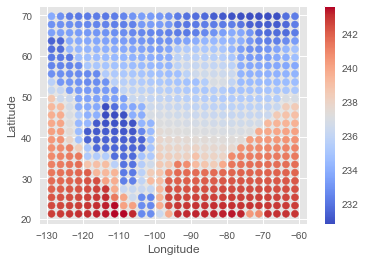

In [18]:
plot_scatter(data, x, y)

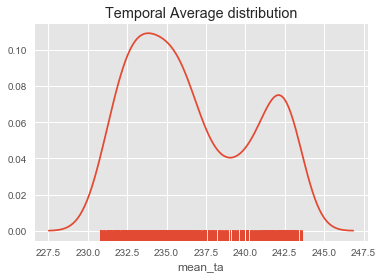

In [19]:
# plot the distribution of the temporal mean
ax = sns.distplot(temporal_avg_df['mean_ta'], rug=True, hist=False)
ax.set_title("Temporal Average distribution")
plt.show()

# Step 4: Calculate Zonal Average
This operation computes a zonal mean of the data as a function of time and latitude.
The only independent variables remaining are latitude and time.

In [20]:
zonal_avg = df.groupby('lat', 'time')\
              .agg(F.avg('ta').alias('mean_ta'))\
              .orderBy(F.col('lat'), F.col('time')).cache()
zonal_avg.show()

+------------------+-------------------+------------------+
|               lat|               time|           mean_ta|
+------------------+-------------------+------------------+
|21.235955056179776|2006-01-16 12:00:00|240.63244262956704|
|21.235955056179776|2006-02-15 00:00:00| 241.0041486842658|
|21.235955056179776|2006-03-16 12:00:00|241.01563464749245|
|21.235955056179776|2006-04-16 00:00:00|241.38070229150915|
|21.235955056179776|2006-05-16 12:00:00|241.71975753849668|
|21.235955056179776|2006-06-16 00:00:00|242.10359871156754|
|21.235955056179776|2006-07-16 12:00:00|  243.025920173596|
|21.235955056179776|2006-08-16 12:00:00|243.39395702731224|
|21.235955056179776|2006-09-16 00:00:00|243.37296900255927|
|21.235955056179776|2006-10-16 12:00:00| 242.5644244818852|
|21.235955056179776|2006-11-16 00:00:00|241.55782674153645|
|21.235955056179776|2006-12-16 12:00:00| 241.3238802017704|
|21.235955056179776|2007-01-16 12:00:00|240.65969933950774|
|21.235955056179776|2007-02-15 00:00:00|

## 4.1 Visualize Zonal Average

In [21]:
zonal_avg_df = zonal_avg.toPandas()
zonal_avg_df.describe()

,lat,mean_ta
count,1500.000000,1500.000000
mean,45.505618,236.722027
std,14.589116,5.043879
min,21.235955,220.987149
25%,33.370787,233.258303
50%,45.505618,237.660850
75%,57.640449,240.841177
max,69.775281,243.973577


In [22]:
zonal_avg_df.dtypes

lat        float64
time        object
mean_ta    float64
dtype: object

In [23]:
zonal_avg_df = zonal_avg_df.set_index('time')

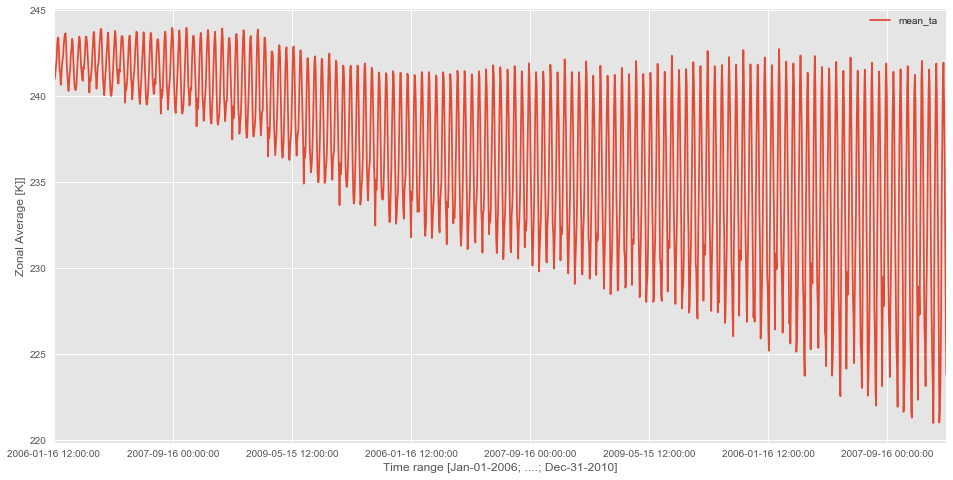

In [24]:
ax = zonal_avg_df['mean_ta'].plot(legend=True, figsize=(16, 8))
ax.set_xlabel("Time range [Jan-01-2006; ....; Dec-31-2010]")
ax.set_ylabel("Zonal Average [K]]")
plt.show()

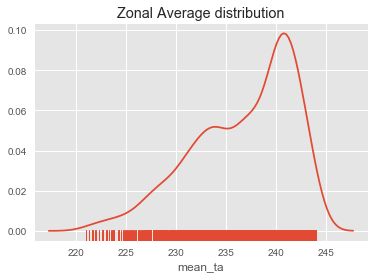

In [25]:
# plot the distribution of the zonal average
ax = sns.distplot(zonal_avg_df['mean_ta'], rug=True, hist=False)
ax.set_title("Zonal Average distribution")
plt.show()

# Step 5: Calculate Spatial Average
This operation computes a spatial mean. For each month, the temperature data at each spatial grid point is averaged together to generate one value.

In [26]:
spatial_avg = df.groupby('time')\
                .agg(F.avg('ta').alias('mean_ta'))\
                .orderBy(F.col('time')).cache()
spatial_avg.show()

+-------------------+------------------+
|               time|           mean_ta|
+-------------------+------------------+
|2006-01-16 12:00:00|231.59926081445633|
|2006-02-15 00:00:00|232.37893242814513|
|2006-03-16 12:00:00| 234.1541619403338|
|2006-04-16 00:00:00|235.78591857085357|
|2006-05-16 12:00:00|238.01055345426494|
|2006-06-16 00:00:00|240.42150196670758|
|2006-07-16 12:00:00| 241.9528985937708|
|2006-08-16 12:00:00| 241.2648552284146|
|2006-09-16 00:00:00| 239.6473727575904|
|2006-10-16 12:00:00|237.19174075318733|
|2006-11-16 00:00:00|234.90129093010106|
|2006-12-16 12:00:00|232.37434658849983|
|2007-01-16 12:00:00| 233.7475353484458|
|2007-02-15 00:00:00|234.06008903985523|
|2007-03-16 12:00:00|234.13952266820945|
|2007-04-16 00:00:00|236.35817862969358|
|2007-05-16 12:00:00|238.67507688947597|
|2007-06-16 00:00:00| 240.9092952795669|
|2007-07-16 12:00:00|242.37356627412072|
|2007-08-16 12:00:00|241.68422413936645|
+-------------------+------------------+
only showing top

## 5.1 Visualize Spatial Average


In [27]:
spatial_avg_df = spatial_avg.toPandas()
spatial_avg_df.describe()

,mean_ta
count,60.000000
mean,236.757677
std,3.538398
min,231.549194
25%,233.926710
50%,236.512822
75%,239.926692
max,242.373566


In [28]:
spatial_avg_df = spatial_avg_df.set_index('time')

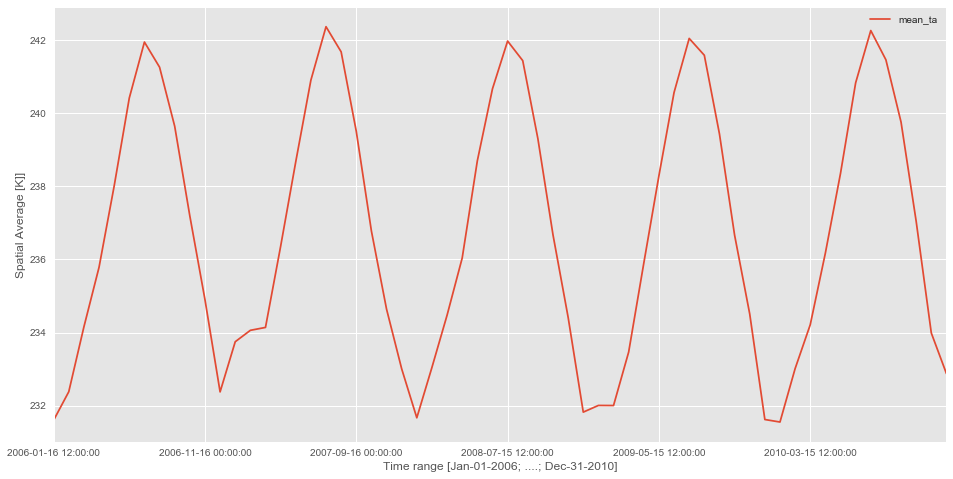

In [29]:
ax = spatial_avg_df['mean_ta'].plot(legend=True, figsize=(16, 8))
ax.set_xlabel("Time range [Jan-01-2006; ....; Dec-31-2010]")
ax.set_ylabel("Spatial Average [K]]")
plt.show()

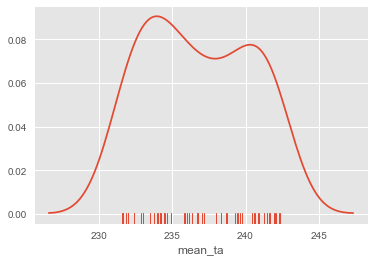

In [30]:
sns.distplot(spatial_avg_df['mean_ta'], rug=True, hist=False)